# Interferon beta stim and genetic perturbations cause changes in gene-gene correlation

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [3]:
%matplotlib inline

In [573]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [574]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [12]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
#sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')

import scme, utils

In [886]:
data_path = '/data/parameter_estimation/20191218/'
#data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/20191218/'


### Plotting function

In [9]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    plt.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    
    

### Read the IFN AnnData object

In [150]:
ifn_adata = sc.read(data_path + 'interferon_data/interferon.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### Function for summarizing DC results

In [151]:
def organize_dc_result(result, adata, ct):
    
    idxs_1 = result['gene_idx_1']
    idxs_2 = result['gene_idx_2']
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
            adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
            result['corr_1'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['corr_2'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_pval'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_fdr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]])),
        columns=['gene_1', 'gene_2', 'corr_1', 'corr_2', 'pval', 'fdr'])
    df['ct'] = ct
    
    return df

def organize_2d_ci_result(ci_dict, adata, idxs_1, idxs_2, ct):
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
            adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
            ci_dict[ct + ' - ctrl']['corr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            ci_dict[ct + ' - stim']['corr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]]
        )),
        columns=['gene_1', 'gene_2', 'corr_ci_1', 'corr_ci_2'])
    df['ct'] = ct
    
    return df

### Find a candidate

ID2 and IFI6, only significant in T cells

In [152]:
ct = 'CD4 T cells'

In [153]:
with open(data_path + 'interferon_data/stim_effect_1d_moments.pkl', 'rb') as f:
    ifn_moment_dict_1d = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_2d.pkl', 'rb') as f:
    ifn_dc_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_1d.pkl', 'rb') as f:
    ifn_de_dv_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_ci_2d.pkl', 'rb') as f:
    ifn_corr_ci = pkl.load(f)

In [154]:
idxs_1 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
organize_2d_ci_result(ifn_corr_ci, ifn_adata, idxs_1, idxs_2, ct).head(5)

,gene_1,gene_2,corr_ci_1,corr_ci_2,ct
0,HOPX,KIF22,0.053326,0.096615,CD4 T cells
1,HOPX,CPNE3,0.026307,0.057584,CD4 T cells
2,HOPX,TESPA1,0.039374,0.043885,CD4 T cells
3,HOPX,LST1,0.134295,0.013745,CD4 T cells
4,HOPX,IRAK4,0.083103,0.065806,CD4 T cells


In [155]:
ifn_dc_df = \
    pd.concat([organize_dc_result(ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')], ifn_adata, ct) for ct in ifn_adata.obs.cell.drop_duplicates().tolist()])\
    .query('corr_1 < 1 & corr_2 < 1 & corr_1 > -1 & corr_2 > -1')
ifn_dc_df_sig = ifn_dc_df.query('fdr < 0.2')

In [159]:
ifn_dc_df.tail(5)

,gene_1,gene_2,corr_1,corr_2,pval,fdr,ct
10954,DPF2,SEC14L1,-0.003169,0.111988,0.633337,0.923867,FCGR3A+ Monocytes
10955,DPF2,DYNC1LI1,0.106405,0.154041,0.889911,0.988166,FCGR3A+ Monocytes
10956,DPF2,EZR,-0.236398,0.012572,0.163584,0.646040,FCGR3A+ Monocytes
10957,DPF2,MAPK1,-0.398264,0.092748,0.042596,0.383538,FCGR3A+ Monocytes
10958,DPF2,KRAS,-0.698448,-0.083349,0.037396,0.363430,FCGR3A+ Monocytes


In [156]:
gene_pair_by_ct = ifn_dc_df_sig\
    .groupby(['gene_1', 'gene_2'])\
    .agg({
        'ct':set,
        'corr_1':set,
        'corr_2':set})\
    .reset_index()
gene_pair_by_ct['ct_count'] = gene_pair_by_ct['ct'].apply(len)

### Bar plot

In [92]:
ci_df.ct.drop_duplicates()

0    CD14+ Monocytes  
0    CD4 T cells      
0    Dendritic cells  
0    CD8 T cells      
0    B cells          
0    FCGR3A+ Monocytes
Name: ct, dtype: object

In [93]:
ifn_dc_df.ct.drop_duplicates()

0      CD14+ Monocytes  
0      CD4 T cells      
851    Dendritic cells  
0      CD8 T cells      
0      B cells          
284    FCGR3A+ Monocytes
Name: ct, dtype: object

In [101]:
idxs_1 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
ci_df = pd.concat([organize_2d_ci_result(ifn_corr_ci, ifn_adata, idxs_1, idxs_2, ct) for ct in ifn_adata.obs.cell.drop_duplicates().tolist()])

In [110]:
corr_ci_df = ifn_dc_df.merge(ci_df, on=['gene_1', 'gene_2', 'ct'], how='inner')

In [117]:
corr_ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))

,gene_1,gene_2,corr_1,corr_2,pval,fdr,ct,corr_ci_1,corr_ci_2
1798,BATF,HSPH1,0.148712,0.074507,0.947705,0.988425,CD14+ Monocytes,0.037485,0.027690
12654,BATF,HSPH1,0.064294,0.396232,0.000003,0.001384,CD4 T cells,0.044503,0.046277
32671,BATF,HSPH1,-0.040936,0.862234,0.049995,0.469808,CD8 T cells,0.056245,0.120785
42563,BATF,HSPH1,0.264371,0.202924,0.278972,0.724032,B cells,0.051511,0.079309
52023,BATF,HSPH1,-0.039749,0.451647,0.445755,0.854807,FCGR3A+ Monocytes,0.245152,0.117533


In [113]:
gene_1 = 'BATF'
gene_2 = 'HSPH1'
ct_corr_info = corr_ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['ct'].tolist()
ctrl_corrs = corr_ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_1'].tolist()
ctrl_ci = corr_ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_ci_1'].tolist()
stim_corrs = corr_ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_2'].tolist()
stim_ci = corr_ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_ci_2'].tolist()

barwidth = 0.3
ctrl_loc = np.arange(len(ct_corr_info)) - barwidth/2
stim_loc = np.arange(len(ct_corr_info)) + barwidth/2

In [114]:
ct_corr_info

['CD14+ Monocytes',
 'CD4 T cells',
 'CD8 T cells',
 'B cells',
 'FCGR3A+ Monocytes']

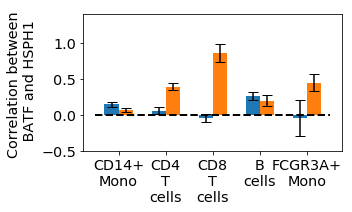

In [202]:
fig = plt.figure(figsize=(5, 3))
plt.bar(
    ctrl_loc, 
    ctrl_corrs, 
    width=barwidth,
    yerr=ctrl_ci,
    capsize=5
);

plt.bar(
    stim_loc, 
    stim_corrs, 
    width=barwidth,
    yerr=stim_ci,
    capsize=5
);

plt.plot([-0.5, len(stim_loc)-0.5], [0, 0], '--', lw=2, color='k');

labels = [a.replace(' ', '\n').replace('Monocytes', 'Mono') for a in ct_corr_info]

plt.xticks(np.arange(len(stim_loc)), labels);
plt.ylim(-0.5, 1.4)
plt.ylabel('Correlation between \n BATF and HSPH1');
fig.tight_layout()
fig.savefig(data_path + 'figures/fig3/BATF_HSPH1_across_ct.pdf')


### Scatter plots

In [120]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0, ax=plt):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    ax.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    

def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order, ax=plt):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 7, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    ax.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    ax.plot(x_range, line, color=sns.color_palette()[color_order])

In [121]:
cd4_ctrl_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD4 T cells - ctrl'][:, [gene_1, gene_2]].X.toarray()
cd4_stim_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD4 T cells - stim'][:, [gene_1, gene_2]].X.toarray()

cd8_ctrl_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD8 T cells - ctrl'][:, [gene_1, gene_2]].X.toarray()
cd8_stim_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD8 T cells - stim'][:, [gene_1, gene_2]].X.toarray()

In [122]:
ifn_adata.var['gene_idx'] = np.arange(ifn_adata.var.shape[0])
gene_1_idx = ifn_adata.var.loc[gene_1, :]['gene_idx']
gene_2_idx = ifn_adata.var.loc[gene_2, :]['gene_idx']

In [123]:
ifn_moment_dict_1d['CD4 T cells - ctrl']['first'][gene_1_idx]

0.6247581

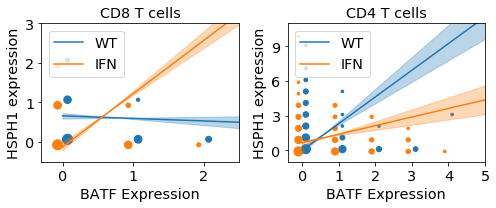

In [200]:
fig = plt.figure(figsize=(7, 3))
plt.subplots_adjust(hspace=0.0, wspace=0.25)


plt.subplot(1, 2, 1)

plot_2d_discrete(cd8_ctrl_data, offset=0.07, ax=plt, size_multiplier=15)
plot_2d_discrete(cd8_stim_data, offset=-0.07, ax=plt, size_multiplier=15)

line_from_correlation(
    corr=ctrl_corrs[2],
    corr_ci=ctrl_ci[2],
    x=cd8_ctrl_data[:, 0],
    y=cd8_ctrl_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD8 T cells - ctrl']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD8 T cells - ctrl']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD8 T cells - ctrl']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD8 T cells - ctrl']['second'][gene_2_idx],
    color_order=0,
    ax=plt
    )

line_from_correlation(
    corr=stim_corrs[1],
    corr_ci=stim_ci[1],
    x=cd8_stim_data[:, 0],
    y=cd8_stim_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD8 T cells - stim']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD8 T cells - stim']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD8 T cells - stim']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD8 T cells - stim']['second'][gene_2_idx],
    color_order=1,
    ax=plt
    )

plt.ylim(-0.5, 3)
#ax2.set_ylim(-0.5, 4)
plt.xlim(-0.3,2.5)


plt.xlabel('{} Expression'.format(gene_1));
plt.ylabel('{} expression'.format(gene_2));
plt.title('CD8 T cells')
plt.legend(['WT', 'IFN'])
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.subplot(1, 2, 2)

plot_2d_discrete(cd4_ctrl_data, offset=0.1, ax=plt, size_multiplier=10)
plot_2d_discrete(cd4_stim_data, offset=-0.1, ax=plt, size_multiplier=10)

line_from_correlation(
    corr=ctrl_corrs[3],
    corr_ci=ctrl_ci[3],
    x=cd4_ctrl_data[:, 0],
    y=cd4_ctrl_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD4 T cells - ctrl']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD4 T cells - ctrl']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD4 T cells - ctrl']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD4 T cells - ctrl']['second'][gene_2_idx],
    color_order=0,
    ax=plt
    )

line_from_correlation(
    corr=stim_corrs[3],
    corr_ci=stim_ci[3],
    x=cd4_stim_data[:, 0],
    y=cd4_stim_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD4 T cells - stim']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD4 T cells - stim']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD4 T cells - stim']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD4 T cells - stim']['second'][gene_2_idx],
    color_order=1,
    ax=plt
    )

plt.ylim(-1, 11)
plt.xlim(-0.4,5)

import matplotlib.ticker as mticker

plt.xlabel('{} Expression'.format(gene_1));
plt.ylabel('{} expression'.format(gene_2));
plt.title('CD4 T cells')
plt.legend(['WT', 'IFN'])
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(3))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

fig.tight_layout()

fig.savefig(data_path + 'figures/fig3/BATF_HSPH1.pdf')


### Marker gene correlation maps

In [887]:
marker_genes = [
    'GNLY', 'NKG7', 'PRF1', 'GZMA', 'GZMB', 'RARRES3',
    'IL7R', 'CD3G', 'CD3D', 'CD3E', 'LCK',
    'CD79A', 'CD79B','MS4A1', 'BANK1', 
    'PF4', 'PPBP',
    'FCGR3A', 'MS4A7', 
    'CD14', 'LYZ', 'S100A9', 'S100A8',
]

In [888]:
len(marker_genes)

23

In [889]:
full_ifn_adata = sc.read(data_path + 'interferon.h5ad')
full_ifn_adata.obs['n_counts'] = full_ifn_adata.X.sum(axis=1)

OSError: Unable to open file (unable to open file: name = '/data/parameter_estimation/20191218/interferon.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
marker_gene_adata = full_ifn_adata[:, marker_genes].copy()
marker_gene_adata.X = marker_gene_adata.X.toarray()
marker_gene_adata.obs['PBMC'] = 'Y'

In [17]:
estimator = scme.SingleCellEstimator(
    adata=marker_gene_adata, 
    group_label='PBMC',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.estimate_beta_sq(tolerance=3)
estimator.beta_sq = 0.012049755522580504
estimator.estimate_parameters()

Computing observed moments for: Y


In [18]:
# Fit a correlation matrix
estimated_corr_mat = estimator.parameters['Y']['corr']
raw_corr_mat = np.corrcoef(marker_gene_adata.X, rowvar=False)
# np.fill_diagonal(estimated_corr_mat, 1)
# np.fill_diagonal(raw_corr_mat, 1)

estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)

In [26]:
marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)

Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: FCGR3A+ Monocytes - stim
Computing observed moments for: Y
Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed momen

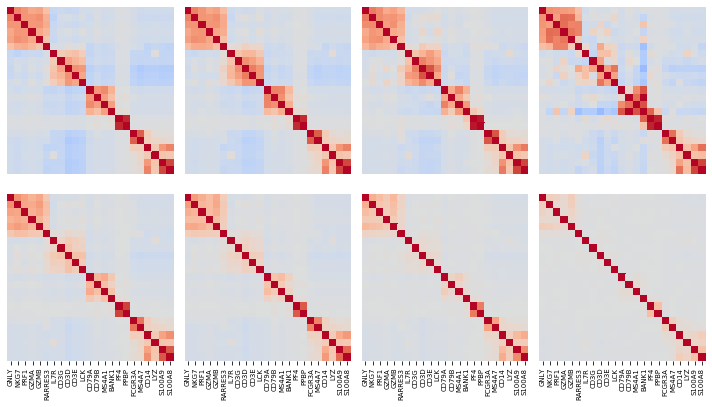

In [31]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)

plt.figure(figsize=(10, 6));
plt.subplots_adjust(hspace=0.1, wspace=0)

for idx, dropout in enumerate([1, 0.5, 0.2, 0.05]):
    #dropout = 0.05

    full_ifn_adata_sampled = full_ifn_adata.copy()
    #full_ifn_adata_sampled.X = full_ifn_adata_sampled.X.toarray().astype(int)

    ifn_adata_sampled = ifn_adata.copy()
    ifn_adata_sampled.X = ifn_adata_sampled.X.toarray().astype(int)
    ifn_adata_sampled.X = stats.binom.rvs(ifn_adata_sampled.X, p=dropout)

    all_gene_estimator = scme.SingleCellEstimator(
        adata=ifn_adata_sampled, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    all_gene_estimator.estimate_beta_sq(tolerance=5)

    marker_gene_adata_sampled = full_ifn_adata[:, marker_genes].copy()
    marker_gene_adata_sampled.X = marker_gene_adata_sampled.X.toarray().astype(int)
    marker_gene_adata_sampled.X = stats.binom.rvs(marker_gene_adata_sampled.X, p=dropout)
    marker_gene_adata_sampled.obs['PBMC'] = 'Y'
    marker_gene_adata_sampled_norm = marker_gene_adata_sampled.copy()
    marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)*1e4
    sc.pp.log1p(marker_gene_adata_sampled_norm)


    estimator = scme.SingleCellEstimator(
        adata=marker_gene_adata_sampled, 
        group_label='PBMC',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    estimator.estimate_beta_sq(tolerance=3)
    estimator.beta_sq = all_gene_estimator.beta_sq
    estimator.estimate_parameters()

    # Fit a correlation matrix
    estimated_corr_mat = estimator.parameters['Y']['corr']
    estimated_corr_mat = np.clip(estimated_corr_mat, -1, 1)
    raw_corr_mat = np.corrcoef(marker_gene_adata_sampled.X, rowvar=False)
    norm_corr_mat = np.corrcoef(marker_gene_adata_sampled_norm.X, rowvar=False)
    estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
    raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)
    norm_corr_mat = pd.DataFrame(norm_corr_mat, index=marker_genes, columns=marker_genes)

    plt.subplot(2, 4, idx + 1);
    sns.heatmap(estimated_corr_mat, cmap='coolwarm', cbar=False,
        xticklabels=False, yticklabels=False, center=0, square=True)
    plt.subplot(2, 4, idx + 5);
    
    # Show norm or raw
    sns.heatmap(raw_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=True, yticklabels=False, center=0, square=True)
plt.tight_layout()

#plt.savefig(data_path + 'figures/fig3/marker_correlations.pdf')

### Regulatory element gene correlation maps

In [883]:
marker_genes = [
    'GNLY', 'NKG7', 'PRF1', 'GZMA', 'GZMB', 'RARRES3',
    'IL7R', 'CD3G', 'CD3D', 'CD3E', 'LCK',
    'CD79A', 'CD79B','MS4A1', 'BANK1', 
    'PF4', 'PPBP',
    'FCGR3A', 'MS4A7', 
    'CD14', 'LYZ', 'S100A9', 'S100A8',
]

In [884]:
len(marker_genes)

23

In [885]:
full_ifn_adata = sc.read(data_path + 'interferon.h5ad')
full_ifn_adata.obs['n_counts'] = full_ifn_adata.X.sum(axis=1)

OSError: Unable to open file (unable to open file: name = '/data/parameter_estimation/interferon.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
marker_gene_adata = full_ifn_adata[:, marker_genes].copy()
marker_gene_adata.X = marker_gene_adata.X.toarray()
marker_gene_adata.obs['PBMC'] = 'Y'

In [17]:
estimator = scme.SingleCellEstimator(
    adata=marker_gene_adata, 
    group_label='PBMC',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.estimate_beta_sq(tolerance=3)
estimator.beta_sq = 0.012049755522580504
estimator.estimate_parameters()

Computing observed moments for: Y


In [18]:
# Fit a correlation matrix
estimated_corr_mat = estimator.parameters['Y']['corr']
raw_corr_mat = np.corrcoef(marker_gene_adata.X, rowvar=False)
# np.fill_diagonal(estimated_corr_mat, 1)
# np.fill_diagonal(raw_corr_mat, 1)

estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)

In [26]:
marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)

Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: FCGR3A+ Monocytes - stim
Computing observed moments for: Y
Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed momen

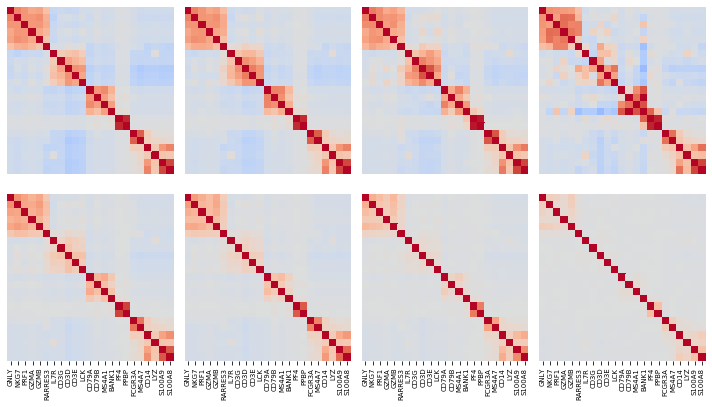

In [31]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)

plt.figure(figsize=(10, 6));
plt.subplots_adjust(hspace=0.1, wspace=0)

for idx, dropout in enumerate([1, 0.5, 0.2, 0.05]):
    #dropout = 0.05

    full_ifn_adata_sampled = full_ifn_adata.copy()
    #full_ifn_adata_sampled.X = full_ifn_adata_sampled.X.toarray().astype(int)

    ifn_adata_sampled = ifn_adata.copy()
    ifn_adata_sampled.X = ifn_adata_sampled.X.toarray().astype(int)
    ifn_adata_sampled.X = stats.binom.rvs(ifn_adata_sampled.X, p=dropout)

    all_gene_estimator = scme.SingleCellEstimator(
        adata=ifn_adata_sampled, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    all_gene_estimator.estimate_beta_sq(tolerance=5)

    marker_gene_adata_sampled = full_ifn_adata[:, marker_genes].copy()
    marker_gene_adata_sampled.X = marker_gene_adata_sampled.X.toarray().astype(int)
    marker_gene_adata_sampled.X = stats.binom.rvs(marker_gene_adata_sampled.X, p=dropout)
    marker_gene_adata_sampled.obs['PBMC'] = 'Y'
    marker_gene_adata_sampled_norm = marker_gene_adata_sampled.copy()
    marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)*1e4
    sc.pp.log1p(marker_gene_adata_sampled_norm)


    estimator = scme.SingleCellEstimator(
        adata=marker_gene_adata_sampled, 
        group_label='PBMC',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    estimator.estimate_beta_sq(tolerance=3)
    estimator.beta_sq = all_gene_estimator.beta_sq
    estimator.estimate_parameters()

    # Fit a correlation matrix
    estimated_corr_mat = estimator.parameters['Y']['corr']
    estimated_corr_mat = np.clip(estimated_corr_mat, -1, 1)
    raw_corr_mat = np.corrcoef(marker_gene_adata_sampled.X, rowvar=False)
    norm_corr_mat = np.corrcoef(marker_gene_adata_sampled_norm.X, rowvar=False)
    estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
    raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)
    norm_corr_mat = pd.DataFrame(norm_corr_mat, index=marker_genes, columns=marker_genes)

    plt.subplot(2, 4, idx + 1);
    sns.heatmap(estimated_corr_mat, cmap='coolwarm', cbar=False,
        xticklabels=False, yticklabels=False, center=0, square=True)
    plt.subplot(2, 4, idx + 5);
    
    # Show norm or raw
    sns.heatmap(raw_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=True, yticklabels=False, center=0, square=True)
plt.tight_layout()

#plt.savefig(data_path + 'figures/fig3/marker_correlations.pdf')

### Large correlation analysis

In [698]:
with open(data_path + 'interferon_data/immune_genes.pkl', 'rb') as f:
    immune_genes = pkl.load(f)
with open(data_path + 'cd4_cropseq_data/ko_genes_to_test.pkl', 'rb') as f:
    ko_genes_to_test = pkl.load(f)
#immune_genes = ko_genes_to_test

In [699]:
full_ifn_adata = sc.read(data_path + 'interferon_data/interferon.h5ad')
full_ifn_adata = full_ifn_adata[:, full_ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
full_ifn_adata.obs['cell_type'] = (full_ifn_adata.obs['cell'].astype(str) + ' - ' + full_ifn_adata.obs['stim'].astype(str)).astype('category')
full_ifn_adata.obs['n_counts'] = full_ifn_adata.X.sum(axis=1)


Trying to set attribute `.obs` of view, making a copy.


In [700]:
immune_gene_adata = full_ifn_adata[:, immune_genes].copy()
immune_gene_adata.X = immune_gene_adata.X.toarray()

In [701]:
immune_gene_adata.obs['PBMC'] = 'Y'

In [702]:
estimator = scme.SingleCellEstimator(
    adata=immune_gene_adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.estimate_beta_sq(tolerance=3)
estimator.beta_sq = 0.012049755522580504
estimator.estimate_parameters()

Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: nan - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: FCGR3A+ Monocytes - stim
Computing observed moments for: nan - stim


In [703]:
def mat_to_df(corr_mat, ct):
    """
        corr_mat is a Pandas dataframe
    """
    idxs1, idxs2 = np.triu_indices(corr_mat.shape[0], k=1)
    corrs =  corr_mat.values[(idxs1, idxs2)]
    genes_1 = corr_mat.index[idxs1]
    genes_2 = corr_mat.index[idxs2]
    
    return pd.DataFrame(data=zip(genes_1, genes_2, corrs), columns=['gene_1', 'gene_2', ct.format(ct)])

In [704]:
corr_df_list = []
for ct in sorted(immune_gene_adata.obs.cell_type.drop_duplicates().tolist())[:-2]:
    
    estimated_corr_mat = get_correlation_map(ct)
    corr_df_list.append(mat_to_df(estimated_corr_mat, ct))

In [870]:
from functools import reduce
corr_mat = reduce(lambda x, y: pd.merge(x, y, on = ['gene_1', 'gene_2']), corr_df_list)
corr_mat['pair'] = corr_mat['gene_1'] + '_' + corr_mat['gene_2']
corr_mat.drop('gene_1', inplace=True, axis=1)
corr_mat.drop('gene_2', inplace=True, axis=1)
corr_mat = corr_mat.set_index('pair')

corr_diff_df = pd.DataFrame(index=corr_mat.index)
gene_pairs = []
for ct in immune_gene_adata.obs.cell.drop_duplicates().tolist()[:-1]:
    
    corr_diff_df[ct] = (corr_mat[ct + ' - stim'] - corr_mat[ct + ' - ctrl']).abs()
    gene_pairs += corr_diff_df.sort_values(ct, ascending=False).head(10).index.tolist()

In [871]:
corr_mat = corr_mat[[x for x in corr_mat.columns if 'Mega' not in x and 'Dend' not in x]]

In [872]:
corr_mat['max_value'] = corr_mat.max(axis=1)
corr_mat['min_value'] = corr_mat.min(axis=1)

#corr_mat_final = corr_mat.query('max_value > 0.8 | min_value < -0.3')
corr_mat_final = corr_mat.loc[gene_pairs, :]
corr_mat_final.drop('max_value', axis=1, inplace=True)
corr_mat_final.drop('min_value', axis=1, inplace=True)


In [873]:
corr_mat_final.shape

(80, 12)

In [874]:
corr_mat_final.columns

Index(['B cells - ctrl', 'B cells - stim', 'CD14+ Monocytes - ctrl',
       'CD14+ Monocytes - stim', 'CD4 T cells - ctrl', 'CD4 T cells - stim',
       'CD8 T cells - ctrl', 'CD8 T cells - stim', 'FCGR3A+ Monocytes - ctrl',
       'FCGR3A+ Monocytes - stim', 'NK cells - ctrl', 'NK cells - stim'],
      dtype='object')

In [875]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# corr_mat_final[corr_mat_final.columns] = scaler.fit_transform(corr_mat_final.values)

In [876]:
corr_mat_final.columns

Index(['B cells - ctrl', 'B cells - stim', 'CD14+ Monocytes - ctrl',
       'CD14+ Monocytes - stim', 'CD4 T cells - ctrl', 'CD4 T cells - stim',
       'CD8 T cells - ctrl', 'CD8 T cells - stim', 'FCGR3A+ Monocytes - ctrl',
       'FCGR3A+ Monocytes - stim', 'NK cells - ctrl', 'NK cells - stim'],
      dtype='object')

In [877]:
corr_mat_final.columns = \
    [
        'B\nctrl', 'B\nstim', 'cM\nctrl', 'cM\nstim', 'Th\nctrl', 'Th\nstim', 'Tc\nctrl', 
        'Tc\nstim', 'ncM\nctrl', 'ncM\nstim', 'NK\nctrl', 'NK\nstim']

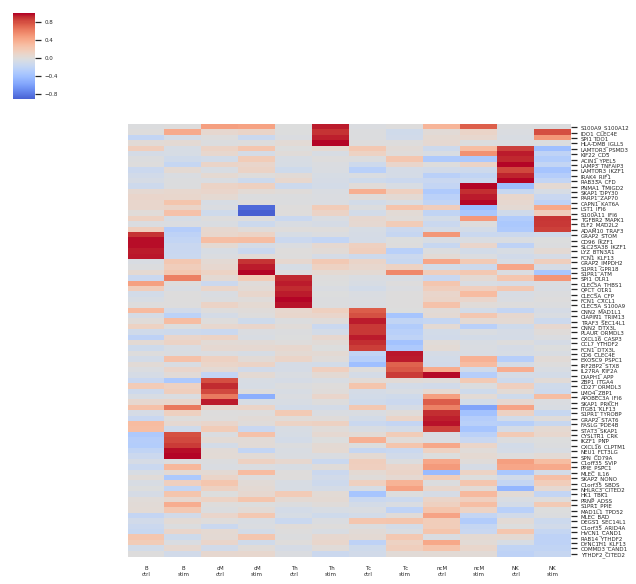

In [882]:
sns.set(font_scale=0.5)
#sns.set(xtick_width=0.1)
corr_mat_final.index.name = None
a = sns.clustermap(
    corr_mat_final, cmap='coolwarm', xticklabels=True, yticklabels=True, 
    center=0, square=False, row_cluster=True, col_cluster=False)
a.ax_row_dendrogram.set_visible(False)
a.savefig('diff_correlation_few.pdf')

In [432]:
def get_correlation_map(cell_type):
    
    estimated_corr_mat = estimator.parameters[cell_type]['corr']
    estimated_corr_mat[(estimated_corr_mat < -1) | (estimated_corr_mat > 1) | np.isnan(estimated_corr_mat)] = 0.0
    estimated_corr_mat[np.diag_indices(estimated_corr_mat.shape[0])] = 0
    estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=immune_genes, columns=immune_genes).fillna(0.0)
    
    return estimated_corr_mat

In [435]:
ctrl_estimated_corr_mat = get_correlation_map('CD14+ Monocytes - ctrl')
stim_estimated_corr_mat = get_correlation_map('CD14+ Monocytes - stim')

# ctrl_estimated_corr_mat = get_correlation_map('NK cells - ctrl')
# stim_estimated_corr_mat = get_correlation_map('NK cells - stim')

# ctrl_estimated_corr_mat = get_correlation_map('CD4 T cells - ctrl')
# stim_estimated_corr_mat = get_correlation_map('CD4 T cells - stim')

# ctrl_estimated_corr_mat = get_correlation_map('CD8 T cells - ctrl')
# stim_estimated_corr_mat = get_correlation_map('CD8 T cells - stim')

# ctrl_estimated_corr_mat = get_correlation_map('ctrl')
# stim_estimated_corr_mat = get_correlation_map('stim')

In [436]:
overall_map = sns.clustermap(ctrl_estimated_corr_mat + stim_estimated_corr_mat,cmap='coolwarm',
        xticklabels=False, yticklabels=False, center=0, square=True)
order = overall_map.dendrogram_row.reordered_ind
#genes = np.array(immune_genes)[order[-60:]]
#order = order[-60:]
plt.close()

In [442]:
top_dc_genes_df

,gene_1,gene_2,corr_1,corr_2,pval,fdr,ct
115,HOPX,EBP,-0.089862,0.553310,0.000000e+00,0.000000e+00,CD14+ Monocytes
10,HOPX,CTR9,-0.101353,0.638087,0.000000e+00,0.000000e+00,CD14+ Monocytes
2053,ZNF146,GPR171,-0.074383,0.640496,5.712599e-22,1.562824e-18,CD14+ Monocytes
7199,ZNF593,PTPN22,-0.055611,0.842749,2.238983e-17,4.900239e-14,CD14+ Monocytes
40,HOPX,NME1,-0.028668,0.336308,1.059017e-16,1.931471e-13,CD14+ Monocytes
2968,MAZ,CD320,-0.121208,0.573738,8.304106e-14,1.298169e-10,CD14+ Monocytes
2157,ZNF146,RAB33A,-0.102216,0.435506,1.385125e-12,1.894678e-09,CD14+ Monocytes
2117,ZNF146,ORMDL3,-0.112617,0.340137,2.455839e-12,2.986027e-09,CD14+ Monocytes
2141,ZNF146,PTPN22,-0.098563,0.394655,8.884065e-12,9.721832e-09,CD14+ Monocytes
4203,PARP1,AQP3,0.279124,-0.053490,5.482133e-11,5.453725e-08,CD14+ Monocytes


In [441]:
stim_estimated_corr_mat.iloc[:10, :10]

,LGALS1,ZNF593,SLC25A38,DDX21,PIK3R1,PARP1,TOX4,ZAP70,ICOS,DPF2
LGALS1,0.000000,-0.053219,-0.057094,-0.054985,0.101586,0.111783,0.003585,-0.059778,-0.060884,-0.179923
ZNF593,-0.053219,0.000000,0.074152,0.693161,0.093780,0.426659,0.075345,0.336177,0.125581,0.341521
SLC25A38,-0.057094,0.074152,0.000000,0.084784,0.192468,0.309288,0.163785,0.147310,0.051090,0.182610
DDX21,-0.054985,0.693161,0.084784,0.000000,0.160761,0.132499,0.063937,0.088284,-0.014649,0.162481
PIK3R1,0.101586,0.093780,0.192468,0.160761,0.000000,0.188925,0.161012,0.270499,0.038113,0.158314
PARP1,0.111783,0.426659,0.309288,0.132499,0.188925,0.000000,0.305839,-0.011299,0.112788,0.036636
TOX4,0.003585,0.075345,0.163785,0.063937,0.161012,0.305839,0.000000,-0.004196,0.097820,0.125359
ZAP70,-0.059778,0.336177,0.147310,0.088284,0.270499,-0.011299,-0.004196,0.000000,-0.027808,0.084757
ICOS,-0.060884,0.125581,0.051090,-0.014649,0.038113,0.112788,0.097820,-0.027808,0.000000,0.223324
DPF2,-0.179923,0.341521,0.182610,0.162481,0.158314,0.036636,0.125359,0.084757,0.223324,0.000000


In [440]:
ctrl_estimated_corr_mat.iloc[:10, :10]

,LGALS1,ZNF593,SLC25A38,DDX21,PIK3R1,PARP1,TOX4,ZAP70,ICOS,DPF2
LGALS1,0.000000,-0.059500,-0.126538,-0.110340,-0.015506,-0.071523,-0.120445,-0.069076,-0.058188,-0.182753
ZNF593,-0.059500,0.000000,0.200004,0.283924,0.107373,0.260731,0.220712,0.098853,-0.048927,-0.001361
SLC25A38,-0.126538,0.200004,0.000000,-0.017902,0.097935,0.018827,-0.104037,0.151307,0.174557,-0.137710
DDX21,-0.110340,0.283924,-0.017902,0.000000,0.045986,0.154460,0.058839,0.066867,0.095239,0.021779
PIK3R1,-0.015506,0.107373,0.097935,0.045986,0.000000,0.148991,0.302991,-0.023059,0.063572,0.119882
PARP1,-0.071523,0.260731,0.018827,0.154460,0.148991,0.000000,0.086484,0.063348,0.173037,0.084603
TOX4,-0.120445,0.220712,-0.104037,0.058839,0.302991,0.086484,0.000000,0.018102,0.194970,-0.102141
ZAP70,-0.069076,0.098853,0.151307,0.066867,-0.023059,0.063348,0.018102,0.000000,0.396544,0.042664
ICOS,-0.058188,-0.048927,0.174557,0.095239,0.063572,0.173037,0.194970,0.396544,0.000000,0.078788
DPF2,-0.182753,-0.001361,-0.137710,0.021779,0.119882,0.084603,-0.102141,0.042664,0.078788,0.000000


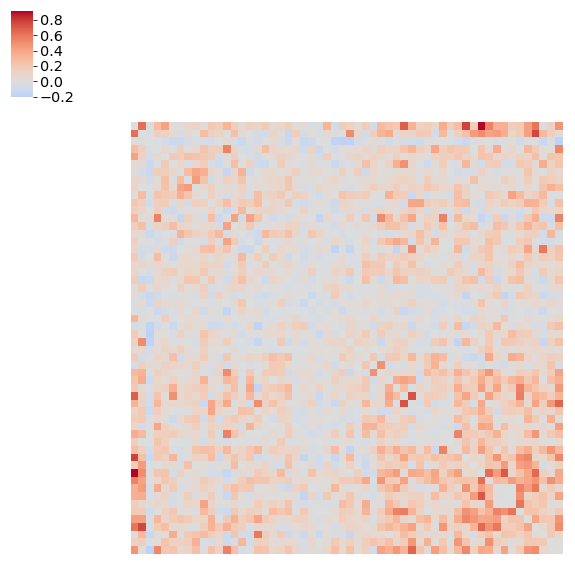

In [437]:

ctrl_estimated_corr_map = sns.clustermap(ctrl_estimated_corr_mat.iloc[order, order],cmap='coolwarm',
        xticklabels=False, yticklabels=False, center=0, square=True, row_cluster=False, col_cluster=False)
#order = ctrl_estimated_corr_map.dendrogram_row.reordered_ind

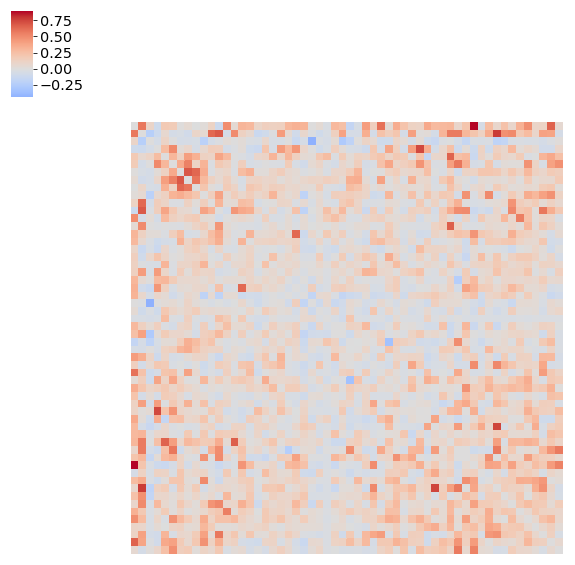

In [438]:
stim_estimated_corr_map = sns.clustermap(stim_estimated_corr_mat.iloc[order, order],cmap='coolwarm',
        xticklabels=False, yticklabels=False, center=0, square=True, row_cluster=False, col_cluster=False)
#order = ctrl_estimated_corr_map.dendrogram_row.reordered_ind